In [1]:
import os
import math
import glob
import numpy as np
import pandas as pd

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from pmdarima.arima import auto_arima

import torch
import torch.nn as nn

import helper

In [2]:
current_path = os.getcwd()
current_path

'd:\\Cornell\\course\\CS6386\\Analyzing-the-Correlation-Between-Retail-Traders--Sentiments-and-Equity-Market-Movements\\Stock_Analysis_Prediction\\Stock'

In [4]:
meme_stocks = ["RIVN", "BB", "SOFI", "GME", "AMC", "PLTR"]

stock_data = {}

for stock in meme_stocks:
    try:
        data = helper.load_stock_data(stock, current_path)
        data['Amount'] = (data['Open'] + data['High'] + data['Low'] + data['Close']) / 4 * data['Volume']
        
        stock_data[stock] = data

    except Exception as e:
        print(f"Error loading data for {stock}: {str(e)}")

In [5]:
stock_data['RIVN'].index

DatetimeIndex(['2021-11-10', '2021-11-11', '2021-11-12', '2021-11-15',
               '2021-11-16', '2021-11-17', '2021-11-18', '2021-11-19',
               '2021-11-22', '2021-11-23',
               ...
               '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
               '2022-12-22', '2022-12-23', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', name='Date', length=287, freq=None)

## 1. Linear Regression

Stock: RIVN
Mean Squared Error: 0.2798465029096094
R-squared: 0.988440116811897


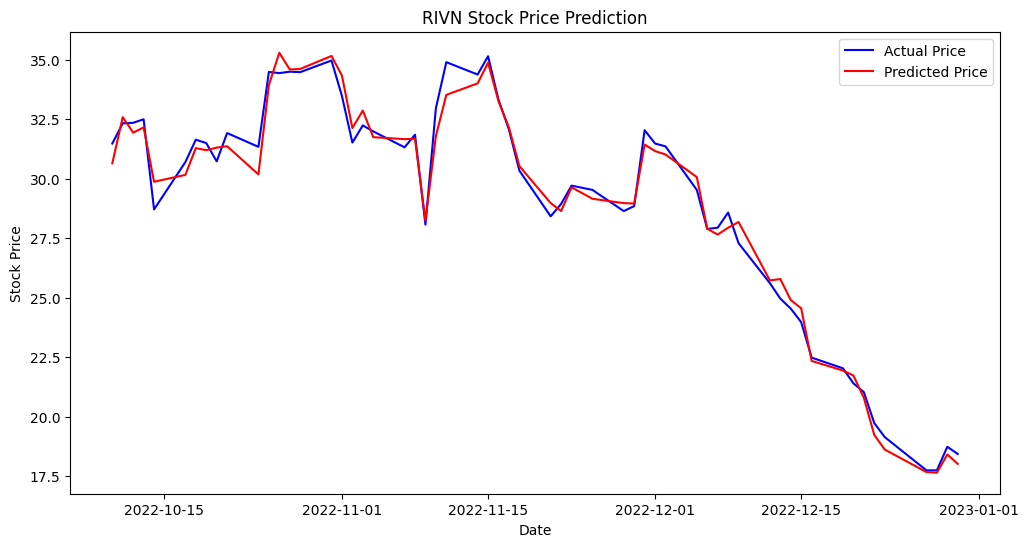

Stock: BB
Mean Squared Error: 0.03593785873777171
R-squared: 0.9955100914420661


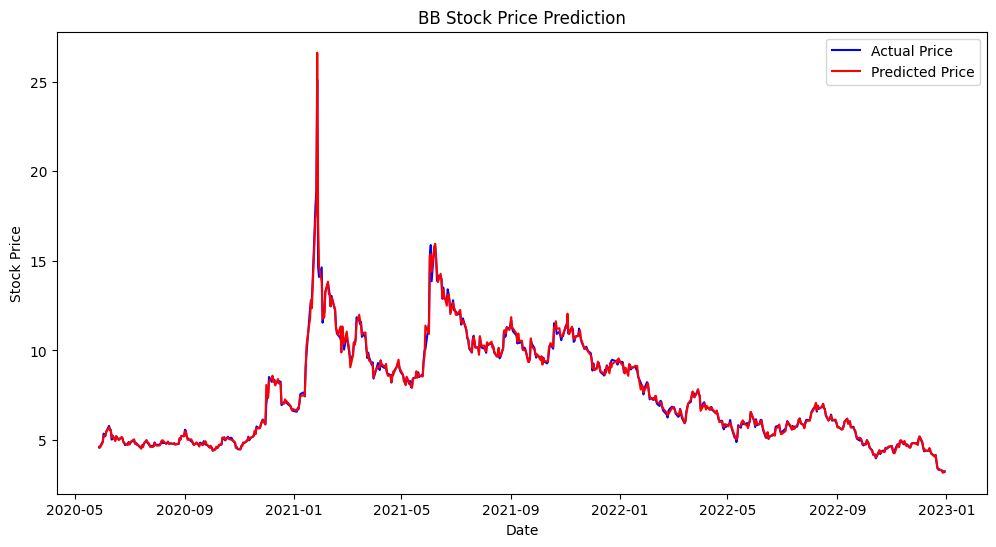

Stock: SOFI
Mean Squared Error: 0.008387151564363227
R-squared: 0.9877548379025918


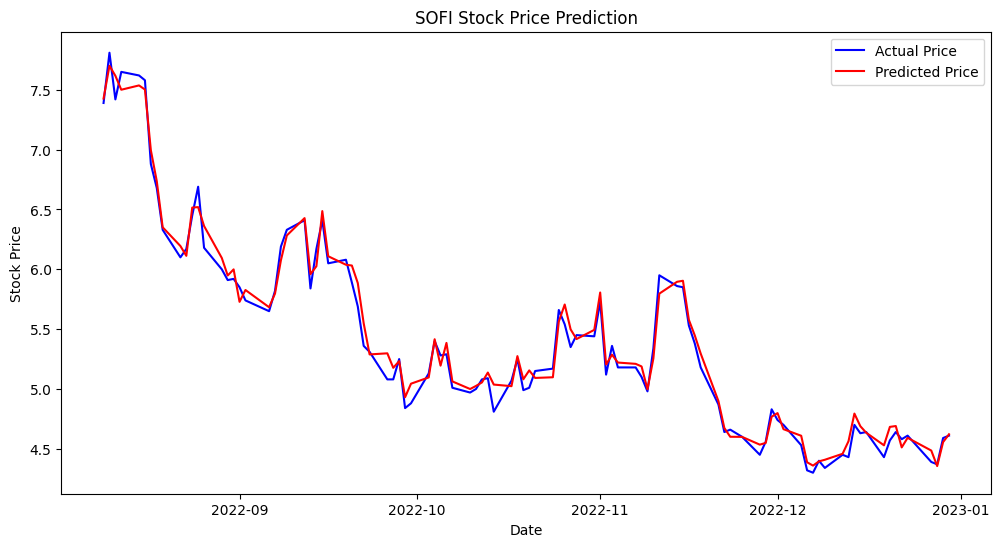

Stock: GME
Mean Squared Error: 3.1775050794331503
R-squared: 0.9902934055604935


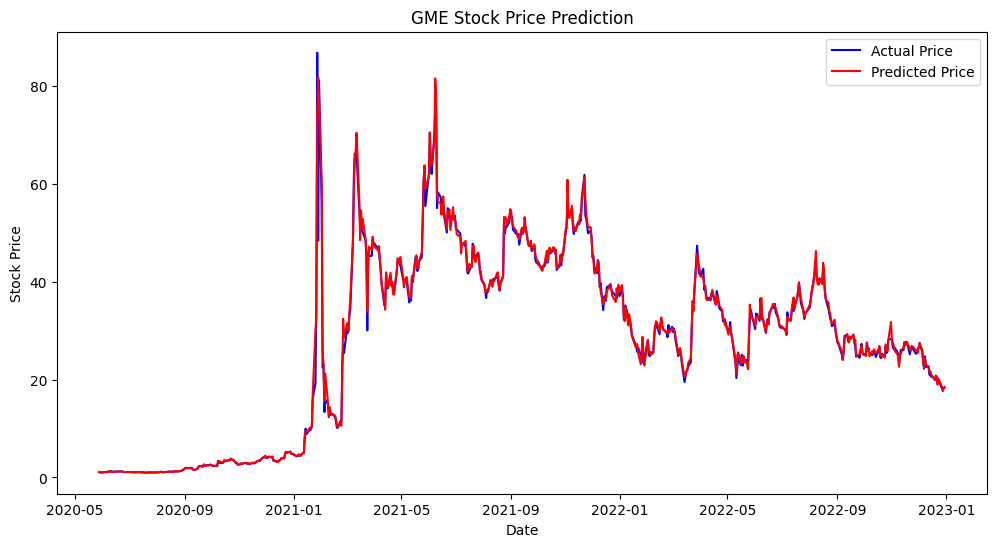

Stock: AMC
Mean Squared Error: 64.76636561784181
R-squared: 0.9968747567231557


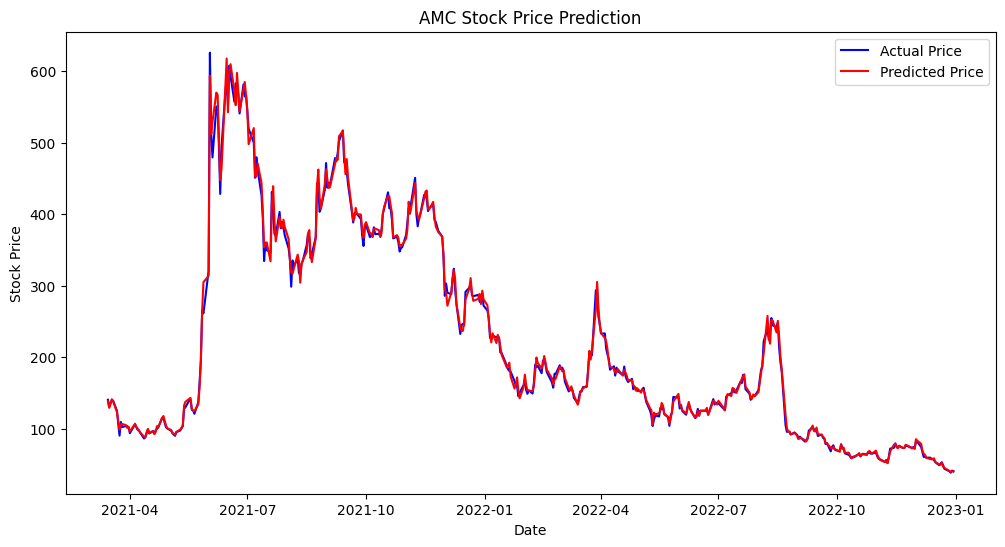

Stock: PLTR
Mean Squared Error: 0.015857826009196163
R-squared: 0.9877830732645991


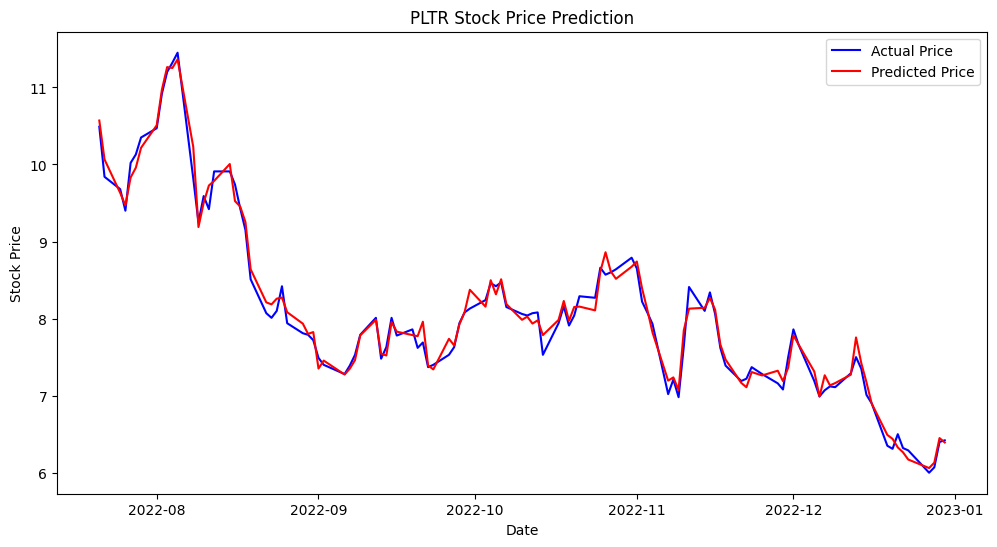

In [6]:
for stock, data in stock_data.items():
    train_size = int(0.8 * len(data))
    train_data = data[:train_size]
    test_data = data[train_size:]

    X_train = train_data[['Open', 'High', 'Low', 'Volume']] # add other variables not related to 'Close'
    y_train = train_data['Close']
    X_test = test_data[['Open', 'High', 'Low', 'Volume']]
    y_test = test_data['Close']

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Stock: {stock}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, y_test, label='Actual Price', color='blue')
    plt.plot(test_data.index, y_pred, label='Predicted Price', color='red')
    plt.title(f"{stock} Stock Price Prediction")
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

## 2. Long Short-Term Memory (LSTM)

In [7]:
input_size = 1  # number of features (stock price)
hidden_size = 64 
num_layers = 2
sequence_length = 5
num_epochs = 5
learning_rate = 0.001

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

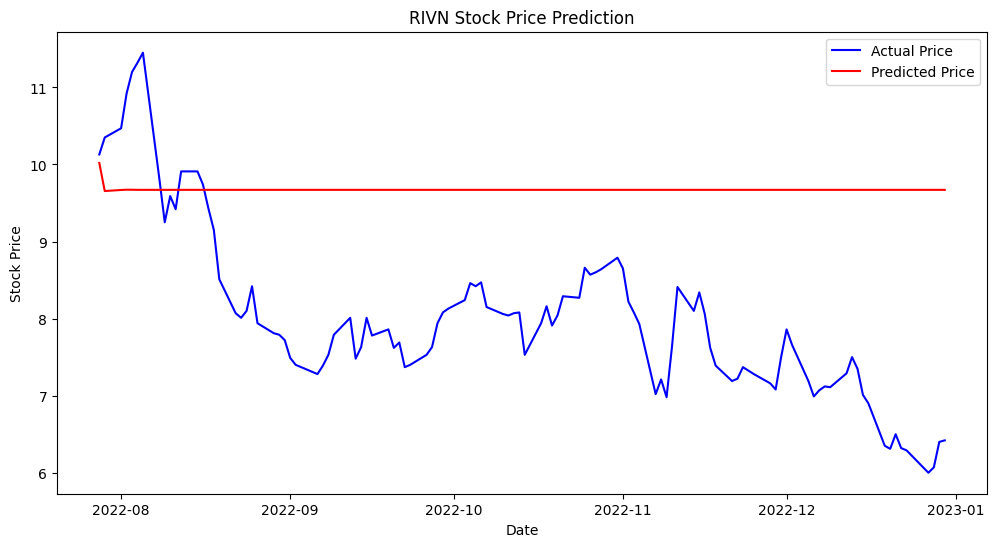

Mean Squared Error (MSE) for RIVN: 3.895507026570585


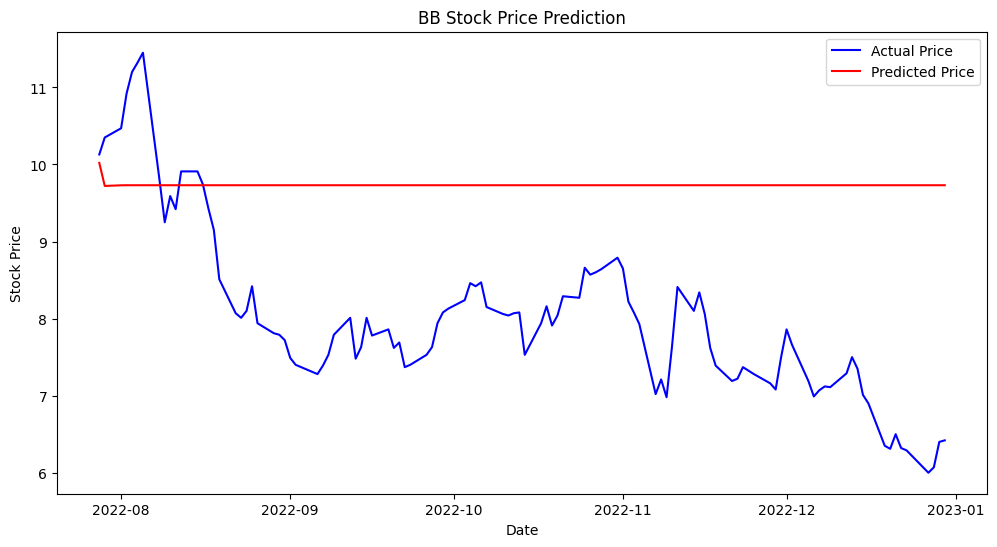

Mean Squared Error (MSE) for BB: 4.0967129614450535


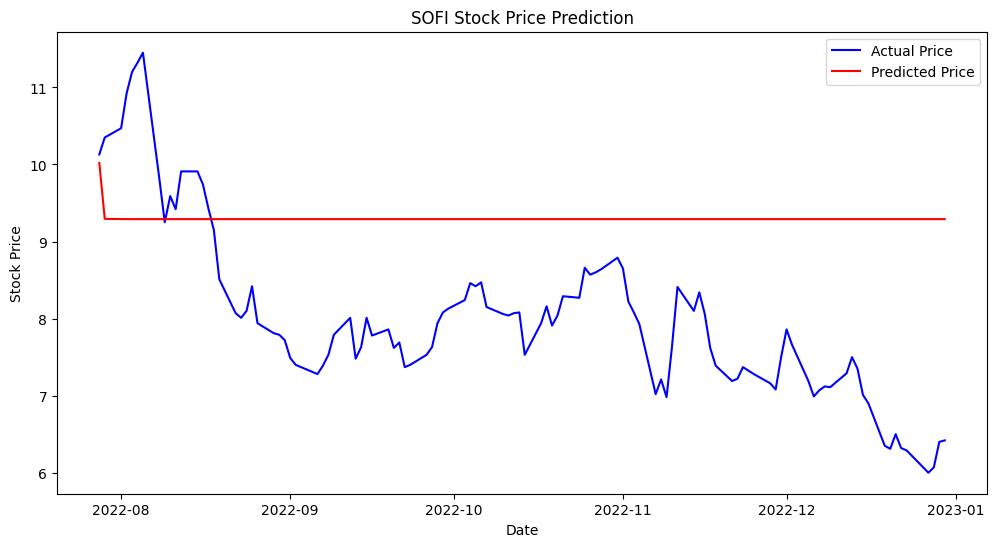

Mean Squared Error (MSE) for SOFI: 2.788261869454124


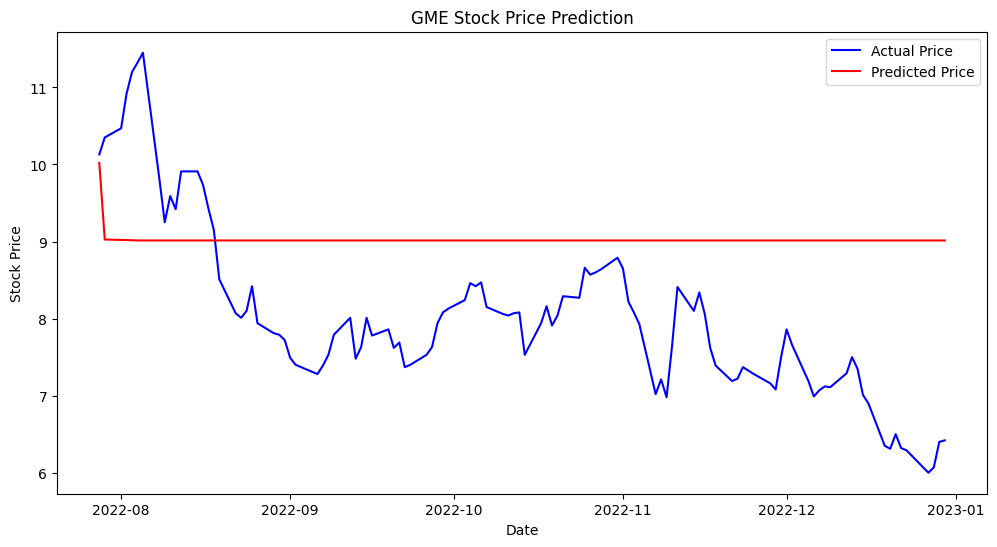

Mean Squared Error (MSE) for GME: 2.163231210328543


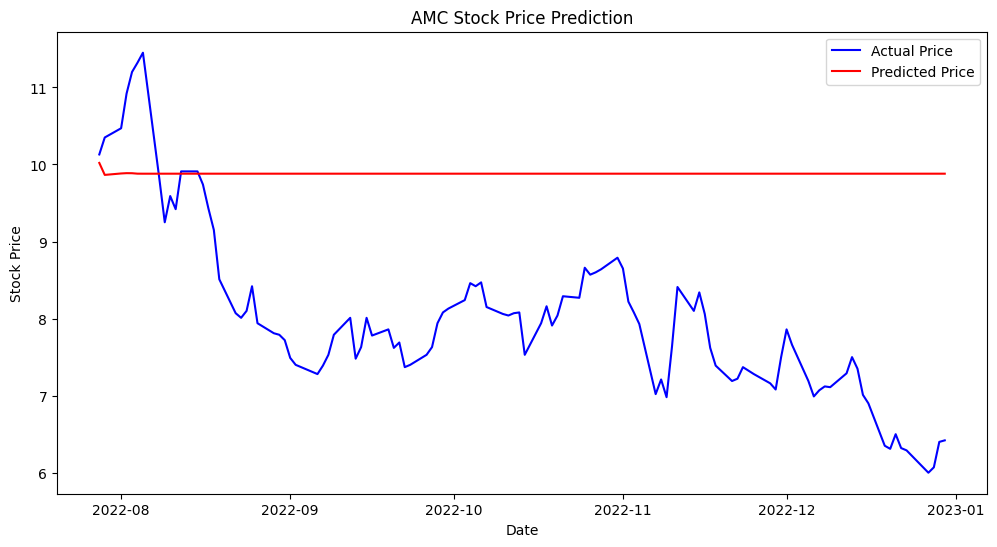

Mean Squared Error (MSE) for AMC: 4.630024980227212


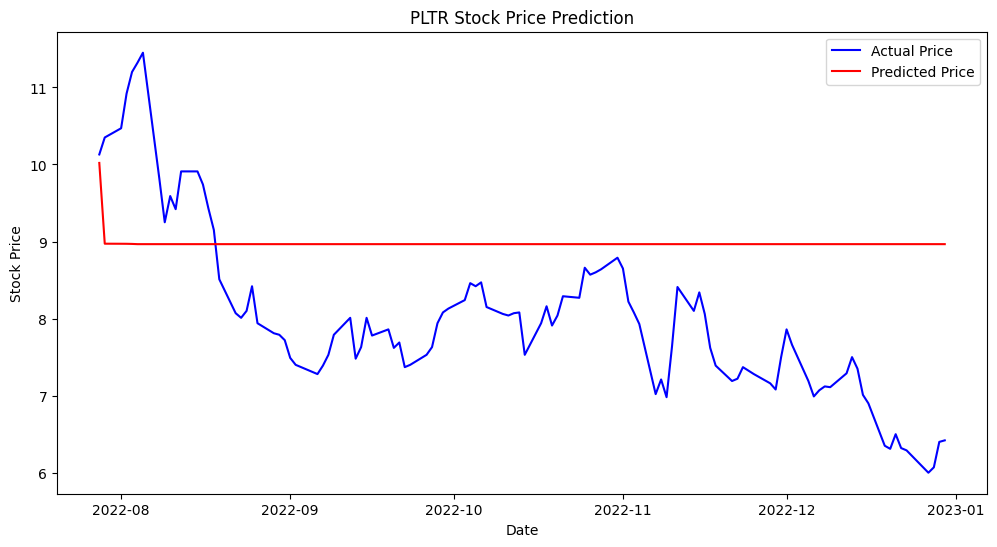

Mean Squared Error (MSE) for PLTR: 2.071246747023188


In [11]:
for stock_name in meme_stocks:
    stock_data_df = helper.load_stock_data(stock, current_path)
    stock_data = stock_data_df['Close']
    original_dates = stock_data_df.index
    

    stock_data = stock_data.values  # Convert to a numpy array
    train_size = int(0.8 * len(stock_data))
    train_data = torch.FloatTensor(stock_data[:train_size]).view(-1)
    test_data = torch.FloatTensor(stock_data[train_size:]).view(-1)

    def create_sequences(data, sequence_length):
        sequences = []
        for i in range(len(data) - sequence_length):
            sequences.append(data[i:i+sequence_length])
        return torch.stack(sequences)

    train_sequences = create_sequences(train_data, sequence_length).to(device)
    test_sequences = create_sequences(test_data, sequence_length).to(device)

    train_loader = torch.utils.data.DataLoader(train_sequences, batch_size=1, shuffle=False)

    model = LSTMModel(input_size, hidden_size, num_layers).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(num_epochs):
        for inputs in train_loader:
            inputs = inputs.view(1, sequence_length, input_size).to(device)
            targets = inputs[:, -1, :].view(1, 1).to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    test_inputs = test_sequences[0, :-1].view(1, sequence_length - 1, input_size).to(device)
    test_outputs = []
    for i in range(len(test_sequences) - 1):
        with torch.no_grad():
            output = model(test_inputs)
            test_outputs.append(output.item())
            test_inputs = torch.cat((test_inputs[:, 1:, :], output.view(1, 1, 1)), dim=1)

    # Map the predicted values back to their original dates
    predicted_dates = original_dates[train_size + sequence_length:]
    predicted_prices = [test_data[sequence_length - 1]] + test_outputs

    mse = mean_squared_error(test_data[sequence_length:-1].numpy(), np.array(test_outputs))

    plt.figure(figsize=(12, 6))
    plt.plot(original_dates[train_size + sequence_length:], test_data[sequence_length:].numpy(), label='Actual Price', color='blue')
    plt.plot(predicted_dates, predicted_prices, label='Predicted Price', color='red')
    plt.title(f"{stock_name} Stock Price Prediction")
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    print(f"Mean Squared Error (MSE) for {stock_name}: {mse}")



    # # using time steps instead of dates
    # model.eval()
    # test_inputs = test_sequences[0, :-1].view(1, sequence_length - 1, input_size).to(device)
    # test_outputs = []
    # for i in range(len(test_sequences) - 1):
    #     with torch.no_grad():
    #         output = model(test_inputs)
    #         test_outputs.append(output.item())
    #         test_inputs = torch.cat((test_inputs[:, 1:, :], output.view(1, 1, 1)), dim=1)

    # test_outputs = [test_data[sequence_length - 1]] + test_outputs

    # mse = mean_squared_error(test_data[sequence_length:].numpy(), np.array(test_outputs))

    # plt.figure(figsize=(12, 6))
    # plt.plot(test_data[sequence_length:].numpy(), label='Actual Price', color='blue')
    # plt.plot(test_outputs, label='Predicted Price', color='red')
    # plt.title(f"{stock_name} Stock Price Prediction with LSTM")
    # plt.xlabel('Time Steps') # The LSTM model doesn't directly work with dates as inputs. Instead, it works with numerical features at each time step.
    # plt.ylabel('Stock Price')
    # plt.legend()
    # plt.show()

    # print(f"Mean Squared Error (MSE) for {stock_name}: {mse}")

## 3. ARIMA (AutoRegressive Integrated Moving Average) 

In [12]:
def train_arima(stock_data):
    train_size = int(0.8 * len(stock_data))
    train, test = stock_data[:train_size], stock_data[train_size:]

    # perform a search to determine the optimal values for p, d, and q, as well as other parameters. 
    # The stepwise argument indicates that it should use a stepwise search to find the best model.
    # The best model will be automatically selected based on the AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion) criteria.
    model = auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True, error_action="ignore")
    
    predictions = model.predict(n_periods=len(test), return_conf_int=False)

    mse = mean_squared_error(test, predictions)
    rmse = math.sqrt(mse)

    return predictions, rmse, test


Stock: RIVN
Root Mean Squared Error (RMSE): 2.1595742781101745


c:\Users\Steven\anaconda3\envs\stock\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Steven\anaconda3\envs\stock\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


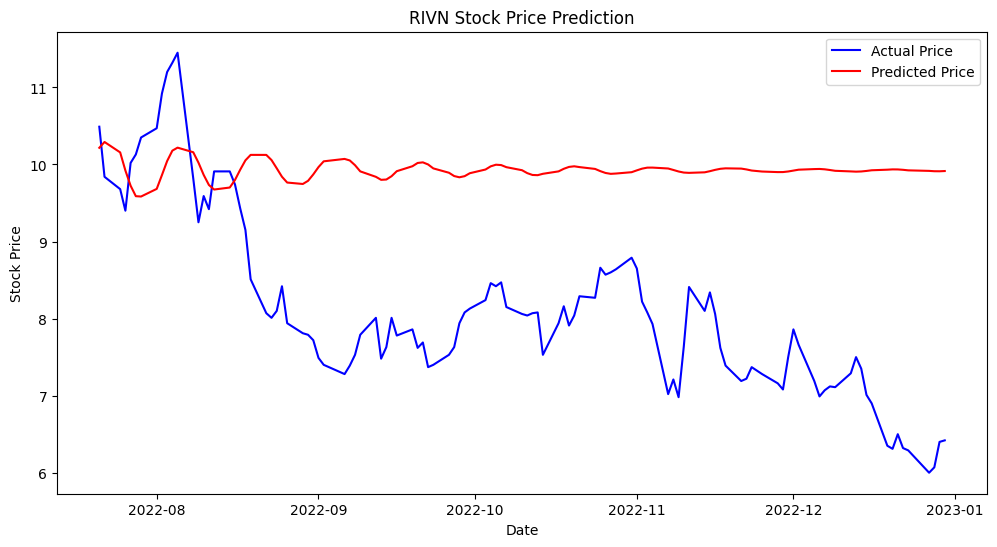

c:\Users\Steven\anaconda3\envs\stock\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Steven\anaconda3\envs\stock\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Stock: BB
Root Mean Squared Error (RMSE): 2.1595742781101745


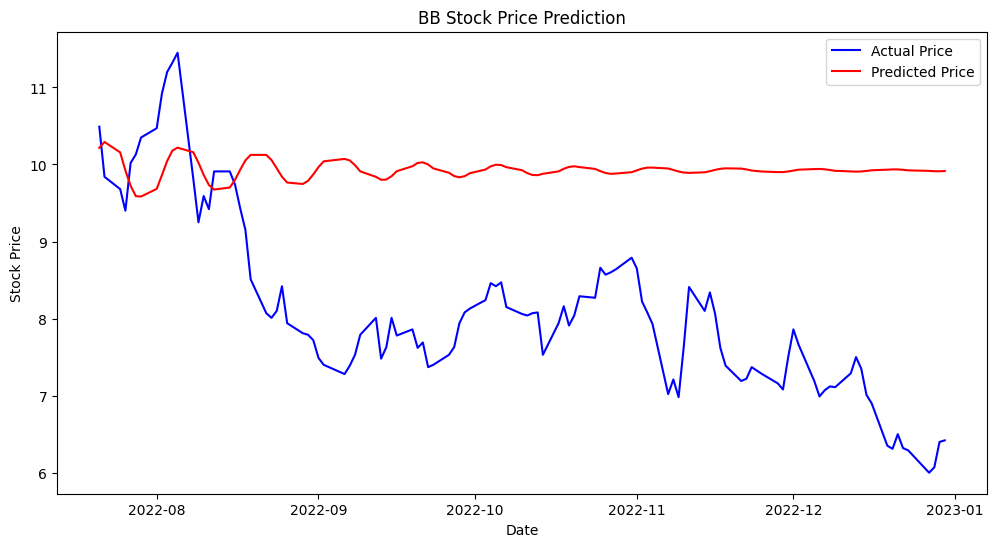

c:\Users\Steven\anaconda3\envs\stock\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Steven\anaconda3\envs\stock\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Stock: SOFI
Root Mean Squared Error (RMSE): 2.1595742781101745


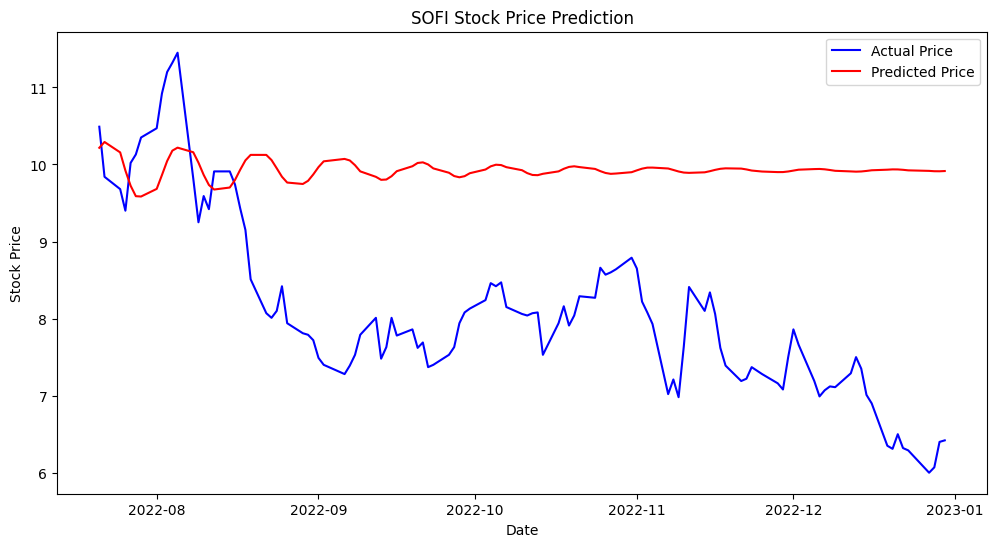

Stock: GME
Root Mean Squared Error (RMSE): 2.1595742781101745


c:\Users\Steven\anaconda3\envs\stock\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Steven\anaconda3\envs\stock\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


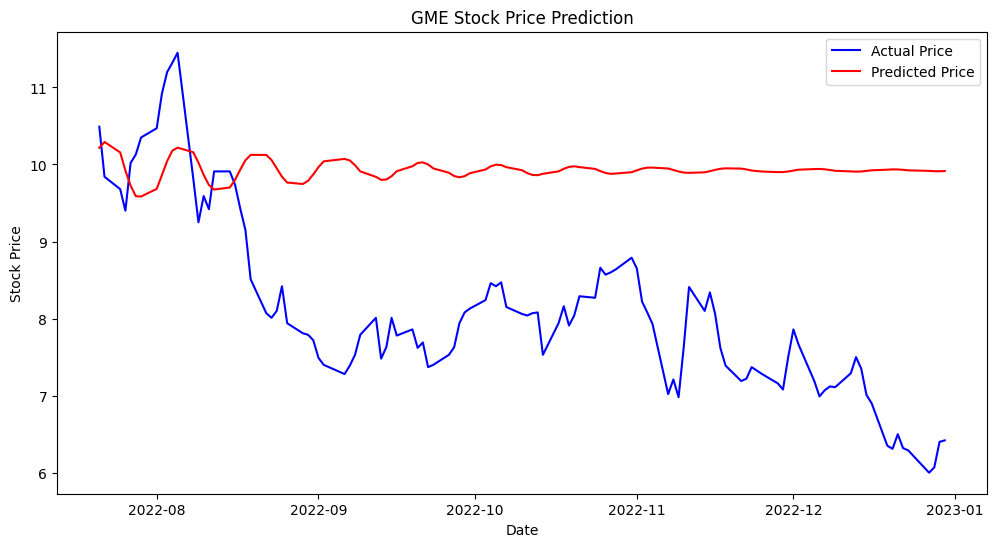

c:\Users\Steven\anaconda3\envs\stock\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Steven\anaconda3\envs\stock\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Stock: AMC
Root Mean Squared Error (RMSE): 2.1595742781101745


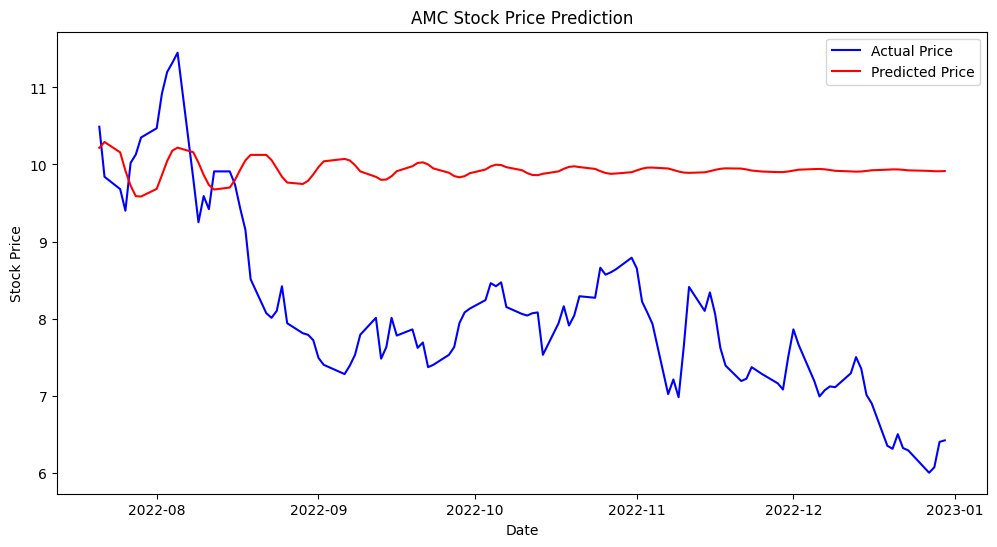

c:\Users\Steven\anaconda3\envs\stock\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Steven\anaconda3\envs\stock\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Stock: PLTR
Root Mean Squared Error (RMSE): 2.1595742781101745


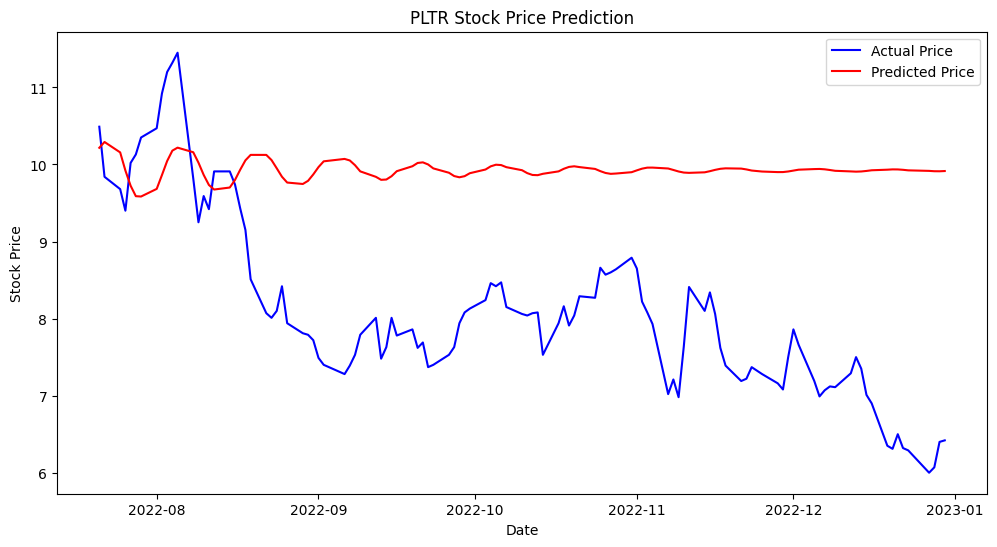

In [13]:
for stock_name in meme_stocks:
    stock_data = helper.load_stock_data(stock, current_path)
    stock_data = stock_data['Close']

    predictions, rmse, test = train_arima(stock_data)

    print(f"Stock: {stock_name}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    plt.figure(figsize=(12, 6))
    plt.plot(stock_data.index[-len(predictions):], test, label='Actual Price', color='blue')
    plt.plot(stock_data.index[-len(predictions):], predictions, label='Predicted Price', color='red')
    plt.title(f"{stock_name} Stock Price Prediction")
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

## 4. Seasonal and Trend decomposition using Loess (STL) 

In [14]:
def train_stl(stock_data):
    train_size = int(0.8 * len(stock_data))
    train, test = stock_data[:train_size], stock_data[train_size:]

    # Decompose the time series into seasonal, trend, and residuals
    result = seasonal_decompose(train, model='additive', period=7)  # adjustable

    # Get the trend component and residuals
    trend = result.trend.dropna()
    residuals = result.resid.dropna()

    # Train a linear regression model on the trend component
    trend_model = LinearRegression()
    X_trend = list(range(len(trend)))
    X_trend = [[x] for x in X_trend]  # Reshape to a 2D array
    trend_model.fit(X_trend, trend)

    # Train a linear regression model on the residuals
    residuals_model = LinearRegression()
    X_residuals = list(range(len(residuals)))
    X_residuals = [[x] for x in X_residuals]  # Reshape to a 2D array
    residuals_model.fit(X_residuals, residuals)

    # Make predictions
    X_test = list(range(len(train) + 1, len(train) + 1 + len(test)))
    X_test = [[x] for x in X_test]  # Reshape to a 2D array
    trend_predictions = trend_model.predict(X_test)
    residuals_predictions = residuals_model.predict(X_test)

    # Combine the predictions of trend and residuals to get the final predictions
    predictions = trend_predictions + residuals_predictions

    mse = mean_squared_error(test, predictions)
    rmse = math.sqrt(mse)

    return predictions, rmse, test


Stock: RIVN
Root Mean Squared Error (RMSE): 2.737546962209202


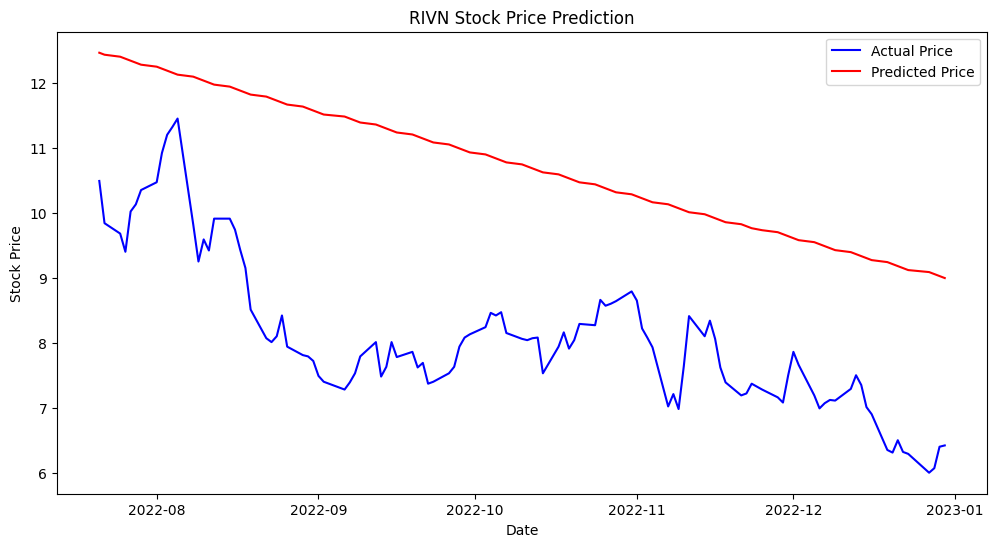

Stock: BB
Root Mean Squared Error (RMSE): 2.737546962209202


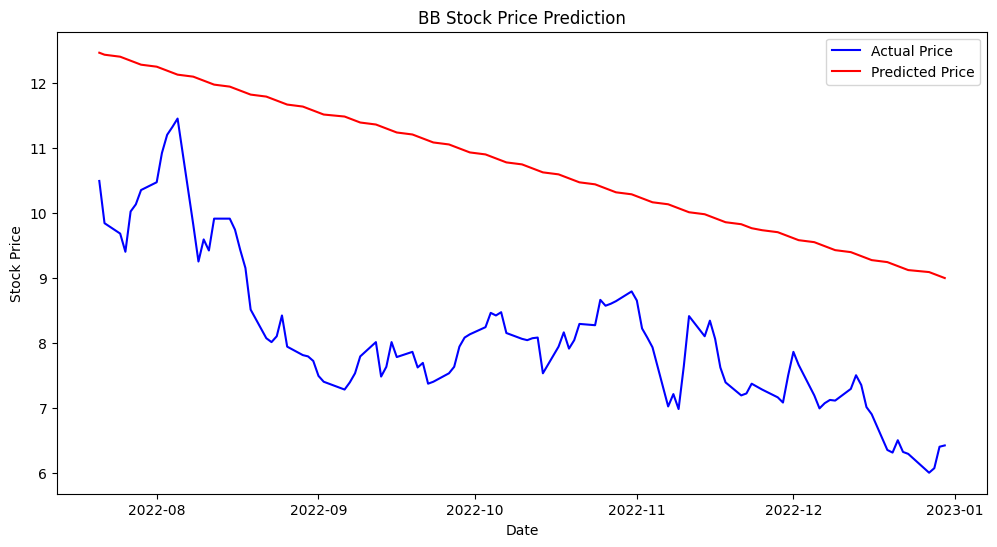

Stock: SOFI
Root Mean Squared Error (RMSE): 2.737546962209202


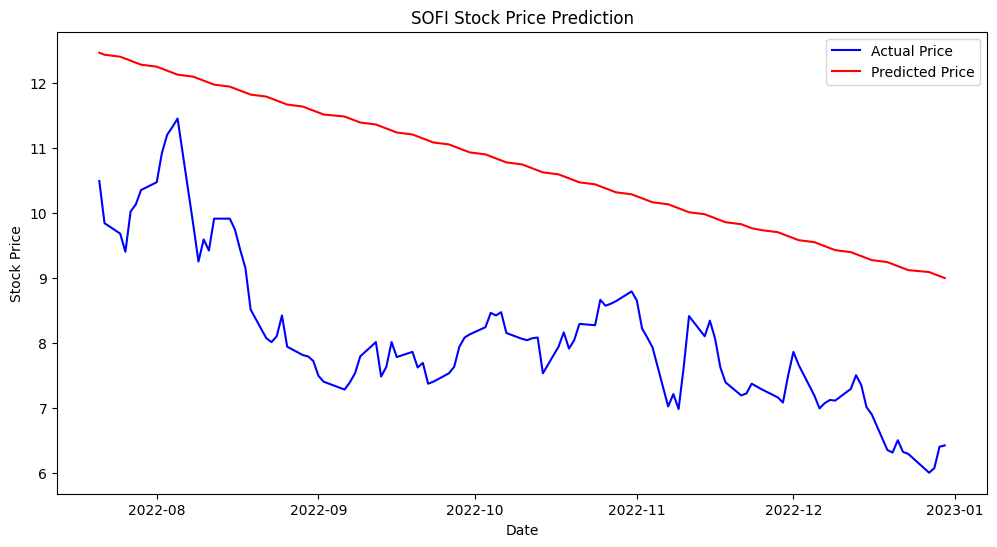

Stock: GME
Root Mean Squared Error (RMSE): 2.737546962209202


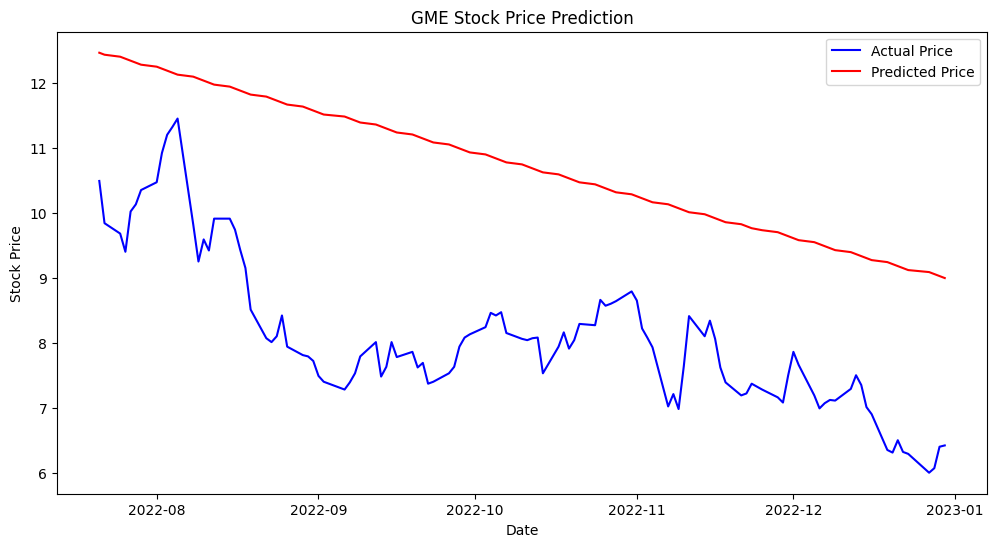

Stock: AMC
Root Mean Squared Error (RMSE): 2.737546962209202


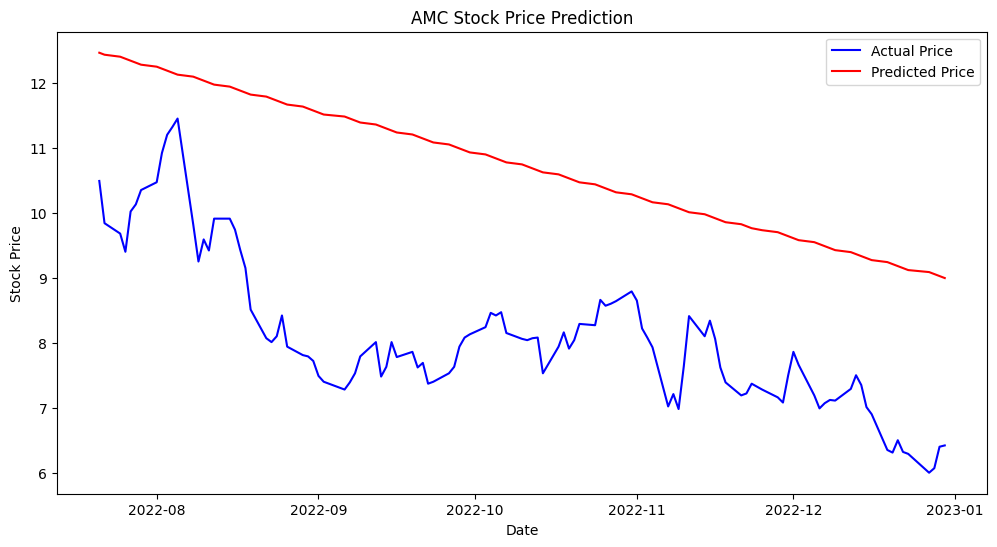

Stock: PLTR
Root Mean Squared Error (RMSE): 2.737546962209202


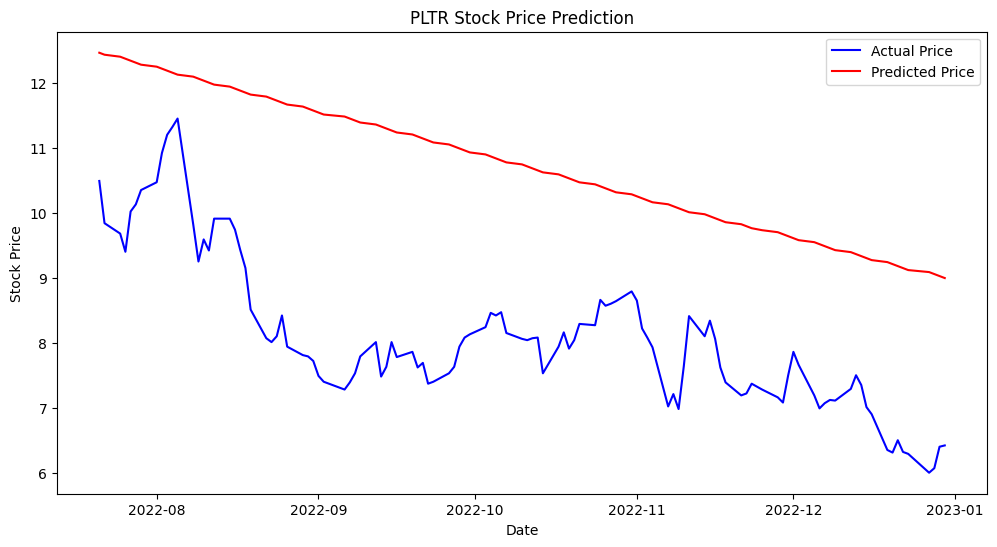

In [15]:
for stock_name in meme_stocks:
    stock_data = helper.load_stock_data(stock, current_path)
    stock_data = stock_data['Close']

    predictions, rmse, test = train_stl(stock_data)

    print(f"Stock: {stock_name}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    plt.figure(figsize=(12, 6))
    plt.plot(stock_data.index[-len(predictions):], test, label='Actual Price', color='blue')
    plt.plot(stock_data.index[-len(predictions):], predictions, label='Predicted Price', color='red')
    plt.title(f"{stock_name} Stock Price Prediction")
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()